# Теория

Выражение для $k$
$$
\begin{matrix}
k_0 = \frac{2\pi}{\lambda} && k_x^2+k_y^2+k_z^2=\varepsilon k_0^2
\end{matrix}
$$

Представления поля внутри слоёв
$$
\begin{matrix}
    \vec{\mathcal{F}}=\left(\begin{matrix}
    E_x \\ E_y \\ H_x \\ H_y
    \end{matrix}\right)
    &&
    \vec{\mathcal{A}}=\left(\begin{matrix}
    A_1 \\ A_2 \\ A_3 \\ A_4
    \end{matrix}\right)
    &&
    \vec{\mathcal{F}} = \hat{F}\vec{\mathcal{A}}
\end{matrix}
$$

Матрица преобразования представлений
$$
\hat{F}=\left(\begin{matrix}
    1 & 0 & 1 & 0 \\
    0 & 1 & 0 & 1 \\
    -\frac{k_xk_y}{k_zk_0} & -\frac{k_z^2+k_y^2}{k_zk_0} & +\frac{k_xk_y}{k_zk_0} & +\frac{k_z^2+k_y^2}{k_zk_0} \\
    +\frac{k_z^2+k_y^2}{k_zk_0} & +\frac{k_xk_y}{k_zk_0} & -\frac{k_z^2+k_y^2}{k_zk_0} & -\frac{k_xk_y}{k_zk_0}
\end{matrix}\right)
$$

Матрица распространения внутри слоя
$$
\begin{matrix}
    \vec{\mathcal{A}}(z+d) = T_d\vec{\mathcal{A}}(z)
    &&
    T_d = \left(\begin{matrix}
    e^{+ik_zd} & 0 & 0 & 0 \\
    0 & e^{+ik_zd} & 0 & 0 \\
    0 & 0 & e^{-ik_zd} & 0 \\
    0 & 0 & 0 & e^{-ik_zd}
    \end{matrix}\right)
\end{matrix}
$$

Переход между слоями
$$
\begin{matrix}
\vec{\mathcal{A}}_2 = T_{12}\vec{\mathcal{A}}_1
&&
T_{12} = \hat{F}_2^{-1}\hat{F}_1
\end{matrix}
$$

В итоге имеем:
$$
\begin{matrix}
    A_{N+1} = T_{20}
    \left(D_2
        \left(
            T_{12}D_1T_{21}D_2
        \right)^{\left[\frac{N}{2}\right]-1}
    T_{12}D_1\right)
    T_{01} \cdot A_0
    &
    \rightarrow
    &
    T_{\sum} = T_{20}\left(D_2
    \left(
        T_{12}D_1T_{21}D_2
    \right)^{\left[\frac{N}{2}\right]-1}
    T_{12}D_1\right)
    T_{01}
\end{matrix}
$$

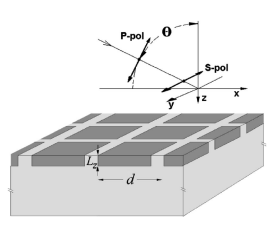

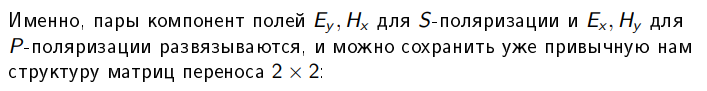

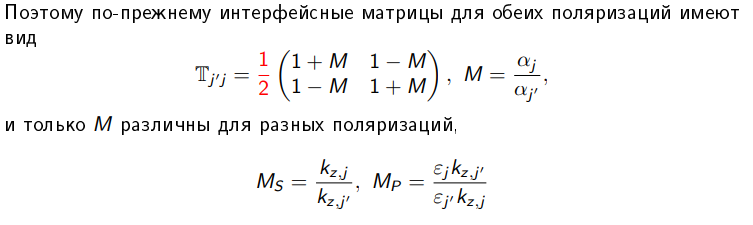

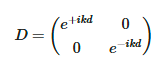

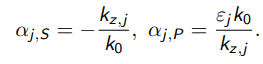

**То есть можно использовать тот-же самый код, но надо кое-что подредактировать**

Раньше считалось $M=\frac{n_1}{n_2}$. а стало $M=\frac{\alpha_1}{\alpha_2}$

Также, везде нужно пересчитать $k_z$

# Настройки отрисовки

In [1]:
from math import sqrt
from math import radians, degrees
from itertools import product
from belashovplot import TiledPlot, FontLibraryClass
from utilities import engineering, scientific
FontLibrary = FontLibraryClass()

# Задачи

## Задача 3.20.1

In [2]:
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Используемое устройство: {device}")

Используемое устройство: cpu


In [50]:
from crystals import CrystalNonOrthogonal, Air, DoubleLayerMassiveNonOrthogonal, LayerNonOrthogonal

resolution_wavelength = 511
central_wavelength = 1240.0E-9
delta_wavelength = 200E-9
wavelength = torch.linspace(central_wavelength-delta_wavelength/2, central_wavelength+delta_wavelength/2, resolution_wavelength, device=device).view(1,-1)
layers = torch.tensor(24,device=device).view(1,1)
n0 = torch.tensor(1.000, device=device).view(1,1)
n1 = torch.tensor(3.000, device=device).view(1,1)
n2 = torch.tensor(3.464, device=device).view(1,1)
d1 = central_wavelength/(4*n1)
d2 = central_wavelength/(4*n2)
theta = torch.deg2rad(torch.linspace(0.,65.,256,device=device))[:-1].view(-1,1)

e0 = 12
E0 = 1.0
Delta = 1.0E-3
# Gamma = 0.
Gamma = 0.1E-3
E = 4.135E-15*3.0E+8 / wavelength
n3 = torch.sqrt(e0*(1 + (2*E0*Delta)/(E0**2 - E**2 - 1j*E*Gamma)))
d3 = torch.ones_like(n3)*10.0E-9

crystal_S = CrystalNonOrthogonal(
    Air(n0), 
    DoubleLayerMassiveNonOrthogonal(wavelength, n1, d1, n2, d2, layers, "S", theta),
    LayerNonOrthogonal(wavelength, n1, d1*4, theta),
    DoubleLayerMassiveNonOrthogonal(wavelength, n2, d2, n1, d1, layers, "S", theta), 
    Air(n0),
    polarization="S",
    theta=theta
)
crystal_P = CrystalNonOrthogonal(
    Air(n0), 
    DoubleLayerMassiveNonOrthogonal(wavelength, n1, d1, n2, d2, layers, "P", theta),
    LayerNonOrthogonal(wavelength, n1, d1*4, theta),
    DoubleLayerMassiveNonOrthogonal(wavelength, n2, d2, n1, d1, layers, "P", theta), 
    Air(n0),
    polarization="P",
    theta=theta
)

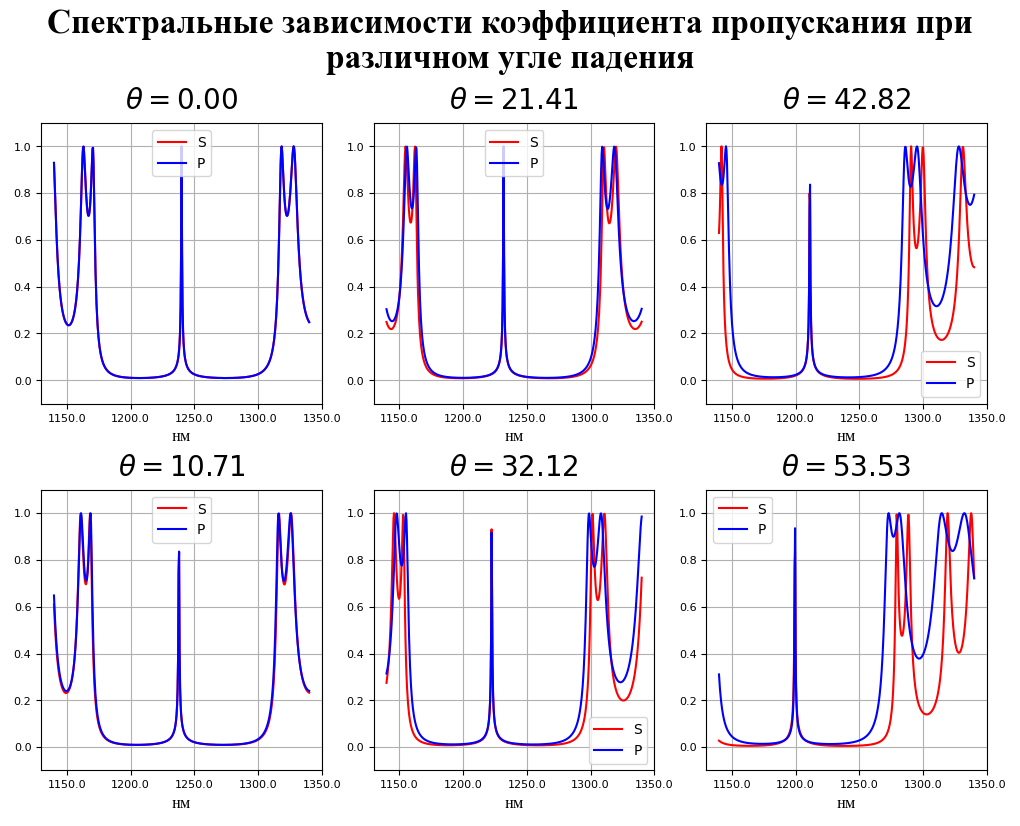

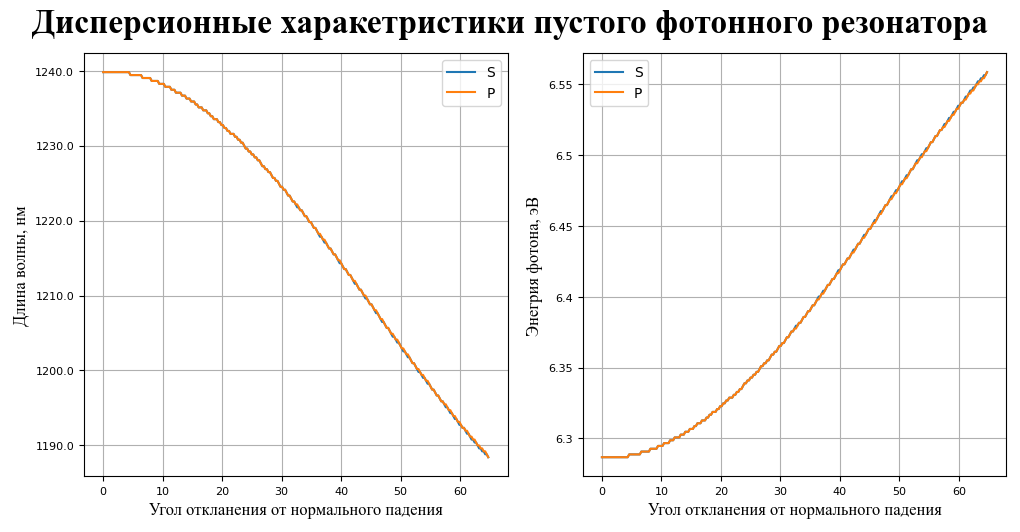

In [59]:
cols = 3
rows = 2

wavelength_less = wavelength.squeeze().cpu()
transition_S = crystal_S.transition[::theta.numel()//(cols*rows)][:cols*rows]
transition_P = crystal_P.transition[::theta.numel()//(cols*rows)][:cols*rows]
theta_less = theta.squeeze()[::theta.numel()//(cols*rows)][:cols*rows]
wl_formatter, wl_unit = engineering.separatedformatter(delta_wavelength, 'м', 3)

plot = TiledPlot(10,None)
plot.FontLibrary = FontLibrary
plot.pad.graph.vertical(0.1)
plot.pad.graph.horizontal(0.05)
plot.pad.title(0.1)
plot.title("Спектральные зависимости коэффициента пропускания при различном угле падения")
for rs, rp, t, (col, row) in zip(transition_S, transition_P, theta_less, product(range(cols),range(rows))):
    axes = plot.axes.add(col, row)
    axes.grid(True)
    axes.xaxis.set_major_formatter(wl_formatter)
    axes.set_ylim(-0.1, 1.1)
    plot.graph.label.x(wl_unit)
    plot.graph.title(f"$\\theta={degrees(t.item()):.2f}$")
    axes.plot(wavelength_less, rs.abs().cpu(), label="S", color="red")
    axes.plot(wavelength_less, rp.abs().cpu(), label="P", color="blue")
    axes.legend()
plot.show()

transition_S, transition_P = crystal_S.transition, crystal_P.transition
differential_S = transition_S[:,1:] - transition_S[:,:-1]
differential_P = transition_P[:,1:] - transition_P[:,:-1]

wavelength_halfed = (wavelength_less[1:] + wavelength_less[:-1])/2
central_wavelength_S = wavelength_halfed.view(1,-1)[:,torch.argmax(differential_S.abs(),dim=1)].squeeze()
central_wavelength_P = wavelength_halfed.view(1,-1)[:,torch.argmax(differential_P.abs(),dim=1)].squeeze()

omega_S = 2*torch.pi*3.0E+8/central_wavelength_S
omega_P = 2*torch.pi*3.0E+8/central_wavelength_P
energy_S = 4.135E-15*omega_S
energy_P = 4.135E-15*omega_P
energy_formatter, energy_unit = engineering.separatedformatter(max(energy_S.max().item(), energy_P.max().item()),'эВ')

plot = TiledPlot(10,None)
plot.FontLibrary = FontLibrary
plot.pad.graph.vertical(0.1)
plot.pad.graph.horizontal(0.05)
plot.pad.title(0.1)
plot.title("Дисперсионные харакетристики пустого фотонного резонатора")

axes = plot.axes.add(0,0)
axes.plot(torch.rad2deg(theta).squeeze().cpu(), central_wavelength_S.cpu(), label="S")
axes.plot(torch.rad2deg(theta).squeeze().cpu(), central_wavelength_P.cpu(), label="P")
axes.grid(True)
axes.legend()
axes.yaxis.set_major_formatter(wl_formatter)
plot.graph.label.y(f"Длина волны, {wl_unit}")
plot.graph.label.x(f"Угол откланения от нормального падения")

axes = plot.axes.add(1,0)
axes.plot(torch.rad2deg(theta).squeeze().cpu(), energy_S.cpu(), label="S")
axes.plot(torch.rad2deg(theta).squeeze().cpu(), energy_P.cpu(), label="P")
axes.grid(True)
axes.legend()
axes.yaxis.set_major_formatter(energy_formatter)
plot.graph.label.y(f"Энегрия фотона, {energy_unit}")
plot.graph.label.x(f"Угол откланения от нормального падения")

plot.show()

In [79]:
from crystals import CrystalNonOrthogonal, Air, DoubleLayerMassiveNonOrthogonal, LayerNonOrthogonal

resolution_wavelength = 1024
central_wavelength = 1240.0E-9
delta_wavelength = 150E-9
wavelength = torch.linspace(central_wavelength-delta_wavelength/2, central_wavelength+delta_wavelength/2, resolution_wavelength, device=device).view(1,-1)
layers = torch.tensor(24,device=device).view(1,1)
n0 = torch.tensor(1.000, device=device).view(1,1)
n1 = torch.tensor(3.000, device=device).view(1,1)
n2 = torch.tensor(3.464, device=device).view(1,1)
d1 = central_wavelength/(4*n1)
d2 = central_wavelength/(4*n2)
theta = torch.deg2rad(torch.linspace(0.,65.,256,device=device))[:-1].view(-1,1)

e0 = 12
E0 = 1.0
Delta = 1.0E-3
Gamma = 0.
# Gamma = 0.1E-3
E = 4.135E-15*3.0E+8 / wavelength
n3 = torch.sqrt(e0*(1 + (2*E0*Delta)/(E0**2 - E**2 - 1j*E*Gamma)))
d3 = torch.ones_like(n3)*10.0E-9

crystal_S = CrystalNonOrthogonal(
    Air(n0), 
    DoubleLayerMassiveNonOrthogonal(wavelength, n1, d1, n2, d2, layers, "S", theta),
    LayerNonOrthogonal(wavelength, n1, (d1*4-d3)*0.25, theta),
    LayerNonOrthogonal(wavelength, n3, d3, theta),
    LayerNonOrthogonal(wavelength, n1, (d1*4-d3)*0.75, theta),
    DoubleLayerMassiveNonOrthogonal(wavelength, n2, d2, n1, d1, layers, "S", theta), 
    Air(n0),
    polarization="S",
    theta=theta
)
crystal_P = CrystalNonOrthogonal(
    Air(n0), 
    DoubleLayerMassiveNonOrthogonal(wavelength, n1, d1, n2, d2, layers, "P", theta),
    LayerNonOrthogonal(wavelength, n1, (d1*4-d3)*0.25, theta),
    LayerNonOrthogonal(wavelength, n3, d3, theta),
    LayerNonOrthogonal(wavelength, n1, (d1*4-d3)*0.75, theta),    
    DoubleLayerMassiveNonOrthogonal(wavelength, n2, d2, n1, d1, layers, "P", theta), 
    Air(n0),
    polarization="P",
    theta=theta
)

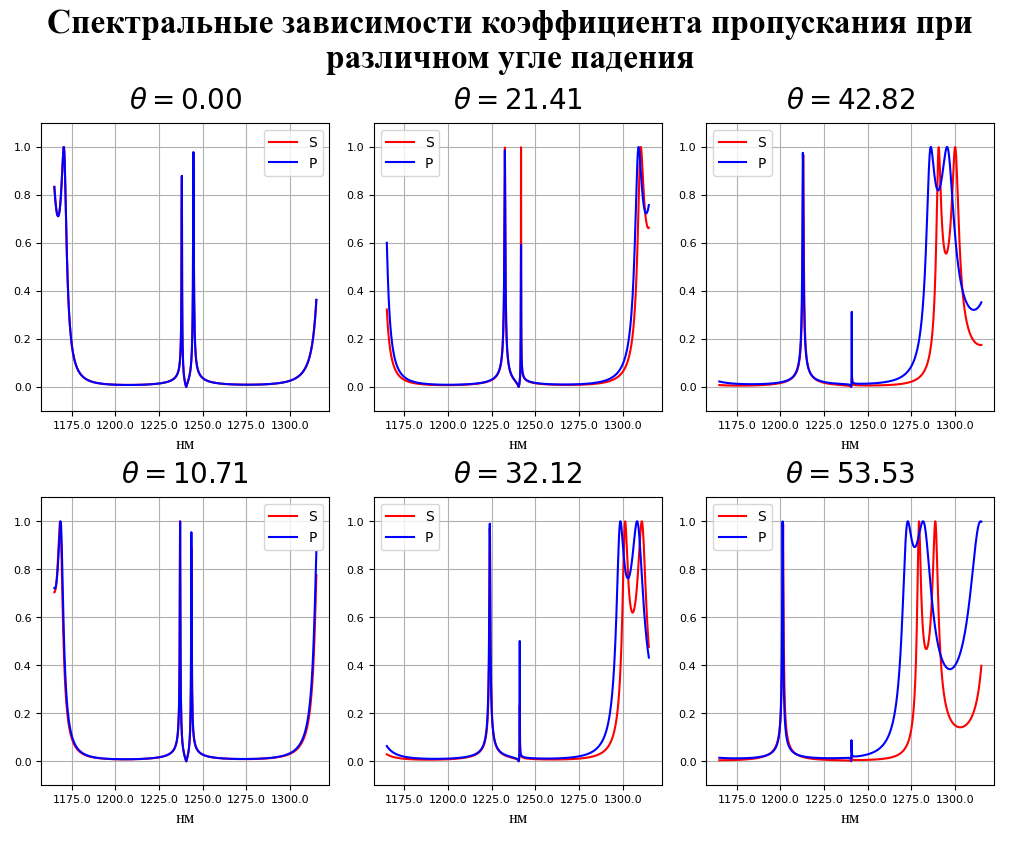

In [88]:
cols = 3
rows = 2

wavelength_less = wavelength.squeeze().cpu()
transition_S = crystal_S.transition[::theta.numel()//(cols*rows)][:cols*rows]
transition_P = crystal_P.transition[::theta.numel()//(cols*rows)][:cols*rows]
theta_less = theta.squeeze()[::theta.numel()//(cols*rows)][:cols*rows]
wl_formatter, wl_unit = engineering.separatedformatter(delta_wavelength, 'м', 3)

plot = TiledPlot(10,None)
plot.FontLibrary = FontLibrary
plot.pad.graph.vertical(0.1)
plot.pad.graph.horizontal(0.05)
plot.pad.title(0.1)
plot.title("Спектральные зависимости коэффициента пропускания при различном угле падения")
for rs, rp, t, (col, row) in zip(transition_S, transition_P, theta_less, product(range(cols),range(rows))):
    axes = plot.axes.add(col, row)
    axes.grid(True)
    axes.xaxis.set_major_formatter(wl_formatter)
    axes.set_ylim(-0.1, 1.1)
    plot.graph.label.x(wl_unit)
    plot.graph.title(f"$\\theta={degrees(t.item()):.2f}$")
    axes.plot(wavelength_less, rs.abs().cpu(), label="S", color="red")
    axes.plot(wavelength_less, rp.abs().cpu(), label="P", color="blue")
    axes.legend()
plot.show()

torch.Size([255, 1]) torch.Size([1, 1024]) torch.Size([1, 1024]) torch.Size([255, 1024])


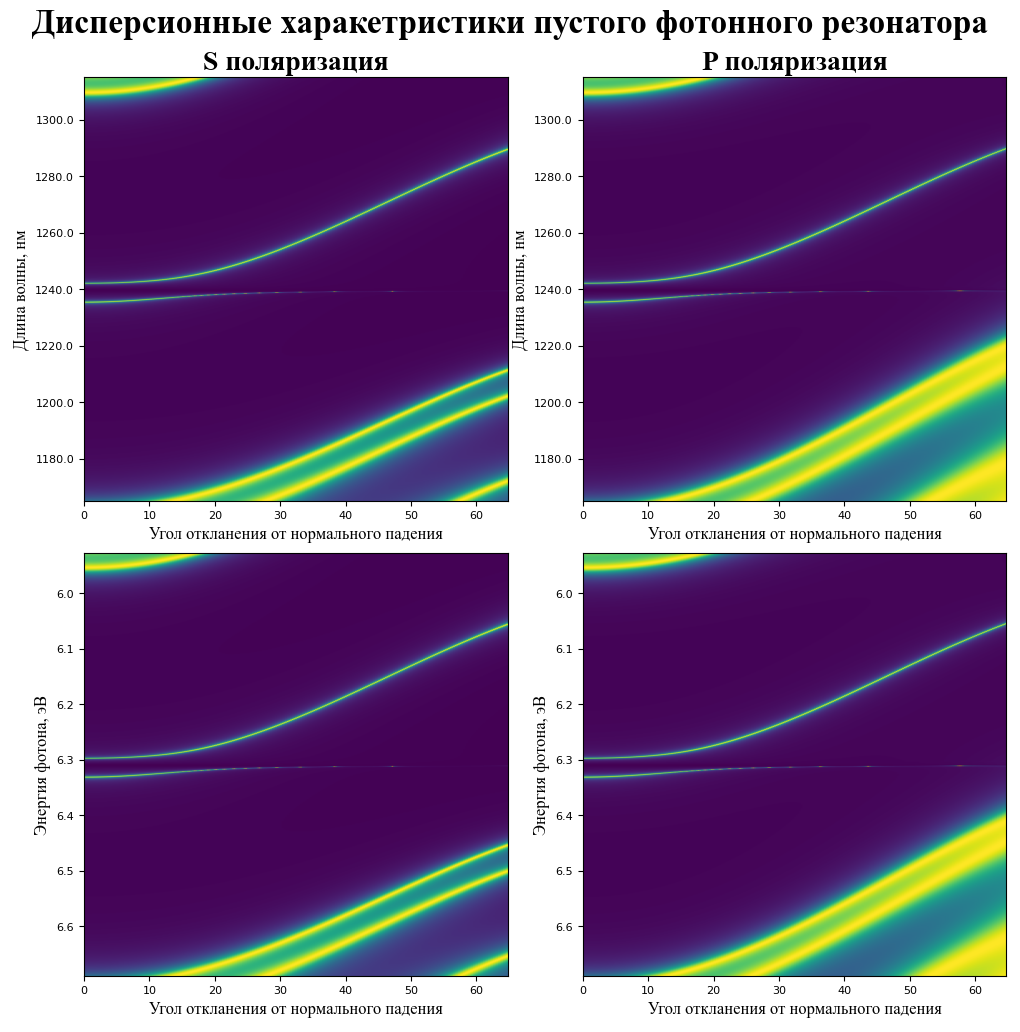

In [108]:
transition_S, transition_P = crystal_S.transition, crystal_P.transition
omega = 2*torch.pi*3.0E+8/wavelength
energy = 4.135E-15*omega
energy_formatter, energy_unit = engineering.separatedformatter(energy.max().item(),'эВ')

print(theta.shape, energy.shape, wavelength.shape, transition_S.shape)

plot = TiledPlot(10,None)
plot.FontLibrary = FontLibrary
plot.pad.graph.vertical(0.1)
plot.pad.graph.horizontal(0.05)
plot.pad.title(0.1)
plot.title("Дисперсионные харакетристики пустого фотонного резонатора")

plot.description.column.top("S поляризация", 0)
axes = plot.axes.add(0,0)
axes.imshow(transition_S.abs().cpu().T, aspect="auto", extent=[torch.rad2deg(theta[0,0]),torch.rad2deg(theta[-1,0]),wavelength[0,0],wavelength[0,-1]])
axes.yaxis.set_major_formatter(wl_formatter)
plot.graph.label.y(f"Длина волны, {wl_unit}")
plot.graph.label.x("Угол откланения от нормального падения")
axes = plot.axes.add(0,1)
axes.imshow(transition_S.abs().cpu().T, aspect="auto", extent=[torch.rad2deg(theta[0,0]),torch.rad2deg(theta[-1,0]),energy[0,0],energy[0,-1]])
axes.yaxis.set_major_formatter(energy_formatter)
plot.graph.label.y(f"Энергия фотона, {energy_unit}")
plot.graph.label.x("Угол откланения от нормального падения")

plot.description.column.top("P поляризация", 1)
axes = plot.axes.add(1,0)
axes.imshow(transition_P.abs().cpu().T, aspect="auto", extent=[torch.rad2deg(theta[0,0]),torch.rad2deg(theta[-1,0]),wavelength[0,0],wavelength[0,-1]])
axes.yaxis.set_major_formatter(wl_formatter)
plot.graph.label.y(f"Длина волны, {wl_unit}")
plot.graph.label.x("Угол откланения от нормального падения")
axes = plot.axes.add(1,1)
axes.imshow(transition_P.abs().cpu().T, aspect="auto", extent=[torch.rad2deg(theta[0,0]),torch.rad2deg(theta[-1,0]),energy[0,0],energy[0,-1]])
axes.yaxis.set_major_formatter(energy_formatter)
plot.graph.label.y(f"Энергия фотона, {energy_unit}")
plot.graph.label.x("Угол откланения от нормального падения")

plot.show()

## Задача 3.20.2